#  Consumer Churn Prediction


### Background

Predicting bank consumer churn is crucial for financial institutions to maintain profitability and sustain customer satisfaction. Identifying potential churners allows banks to proactively address issues, retain valuable customers, and optimize marketing efforts. By understanding the factors influencing customer attrition, such as dissatisfaction with services, competitive offers from other banks, or changes in financial circumstances, banks can implement targeted strategies to mitigate churn. This could involve offering personalized incentives, improving customer service, or enhancing product offerings to better meet customer needs. Moreover, reducing churn can significantly impact a bank's bottom line by preserving revenue streams and minimizing the cost of acquiring new customers. Overall, accurate churn prediction empowers banks to foster long-term customer relationships, enhance customer loyalty, and ultimately drive sustainable business growth.

<img src="https://miro.medium.com/v2/resize:fit:844/1*MyKDLRda6yHGR_8kgVvckg.png" alt="image_description" width="300" height="200">

### Goal

In this project, we will be using  [Kaggle Consumer Churn Dataset](https://www.kaggle.com/adammaus/predicting-churn-for-bank-customers). By leveraging historical data on customer interactions, transactions, and demographics, this project aims to build a model that can effectively distinguish between customers who are likely to churn and those who are likely to stay with the bank.

## Section1: Data importation

In [2]:
# Mount your Google Drive to Collaboratory
# from google.colab import drive
#drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# Find your file path in the left bar and copy the path
import pandas as pd
df=pd.read_csv('Churn_Modelling.csv')

## Section2: Explorative Data Analysis (EDA)


### Part1: Data Inspection (Sanity Check)

In [3]:
# Have a brief view of data -- Understand Each Column
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
# Keep useful Cols
df.drop(columns=['RowNumber', 'CustomerId', 'Surname'], inplace=True)

In [ ]:
# Check Shape
df.shape

(10000, 11)

In [ ]:
# Check missing value (If exists, How to fix it?)
df.isnull().sum(axis = 0)

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [ ]:
# Check unique value
df.nunique()

CreditScore         460
Geography             3
Gender                2
Age                  70
Tenure               11
Balance            6382
NumOfProducts         4
HasCrCard             2
IsActiveMember        2
EstimatedSalary    9999
Exited                2
dtype: int64

In [ ]:
# Check outlier (mean +- 3 std & negative Age? etc.)
df[['CreditScore', 'Age', 'Tenure', 'NumOfProducts','Balance', 'EstimatedSalary']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
Age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
Tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00
NumOfProducts,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00
Balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
EstimatedSalary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48


In [ ]:
# Check if Target Variable are balanced (If exists, how to fix it?)
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

### Part2: Draw Images for Explorative Analysis

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

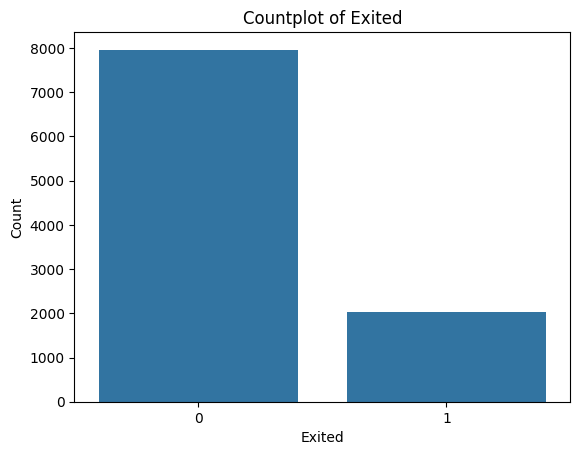

In [ ]:
# countplot easy version
sns.countplot(x='Exited', data=df)
plt.xlabel('Exited')
plt.ylabel('Count')
plt.title('Countplot of Exited')
plt.show()

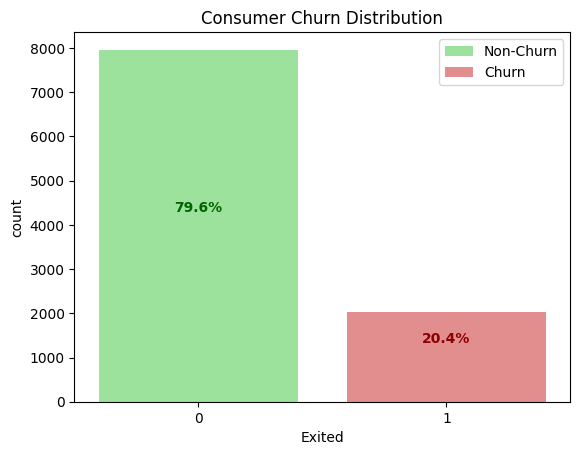

In [ ]:
# Create the countplot with customized colors for default = 0 and default = 1
colors = ["lightgreen", "lightcoral"]
ax = sns.countplot(x='Exited', data=df, palette=colors)

# Calculate percentages and annotate the bars with the percentages
total = len(df['Exited'])
for i, p in enumerate(ax.patches):
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() / 2
    # Set text color based on default status
    text_color = 'darkgreen' if i == 0 else 'darkred'
    ax.annotate(percentage, (x, y), ha='center', color=text_color, xytext=(0, 10), weight='bold',textcoords='offset points')
ax.legend(['Non-Churn', 'Churn'], loc='upper right')
plt.title("Consumer Churn Distribution")
plt.show()

In [ ]:
#Define a function creating a stacked histogram with self-defined bins

def get_variable_distribution(predictor, bins, bin_labels, dataframe):
    # Create a new DataFrame with binned age groups
    dataframe_binned = dataframe.assign(Group=pd.cut(dataframe[predictor], bins=bins, labels=bin_labels, right=False))

    # Group by 'Age_Group' and 'Exited', then count occurrences
    result = dataframe_binned.groupby(['Group', 'Exited']).size().unstack(fill_value=0)

    # Calculate total count for each age group
    total_counts = result.sum(axis=1)

    # Plot the stacked histogram
    fig, ax = plt.subplots(figsize=(10, 6))

    # Loop through each age group and add bars for 'Exited = 0' and 'Exited = 1' inside each bar
    for i, (index, row) in enumerate(result.iterrows()):
        # Calculate percentage for each category
        total = row.sum()
        pct_exited_0 = row[0] / total * 100
        pct_exited_1 = row[1] / total * 100

        # Add bars
        ax.bar(index, row[0], color='lightgreen', bottom=row[1] if i > 0 else None)
        ax.bar(index, row[1], color='lightcoral', bottom=0)

        # Add percentage labels
        ax.text(index, row[0]/2 + row[1], f'{pct_exited_0:.1f}%', ha='center', va='center', color='darkgreen',weight='bold')
        ax.text(index, row[1] / 2, f'{pct_exited_1:.1f}%', ha='center', va='center', color='darkred',weight='bold')

    # Set labels and title
    ax.set_xlabel(predictor + ' Group')
    ax.set_ylabel('Count')
    ax.set_title('Different ' + predictor + ' Groups with Churn Status')
    ax.legend(['Non-Churn', 'Churn'], loc='upper right')

    # Rotate x-axis labels for better visibility
    plt.xticks(rotation=45)

    # Show plot
    plt.tight_layout()
    plt.show()

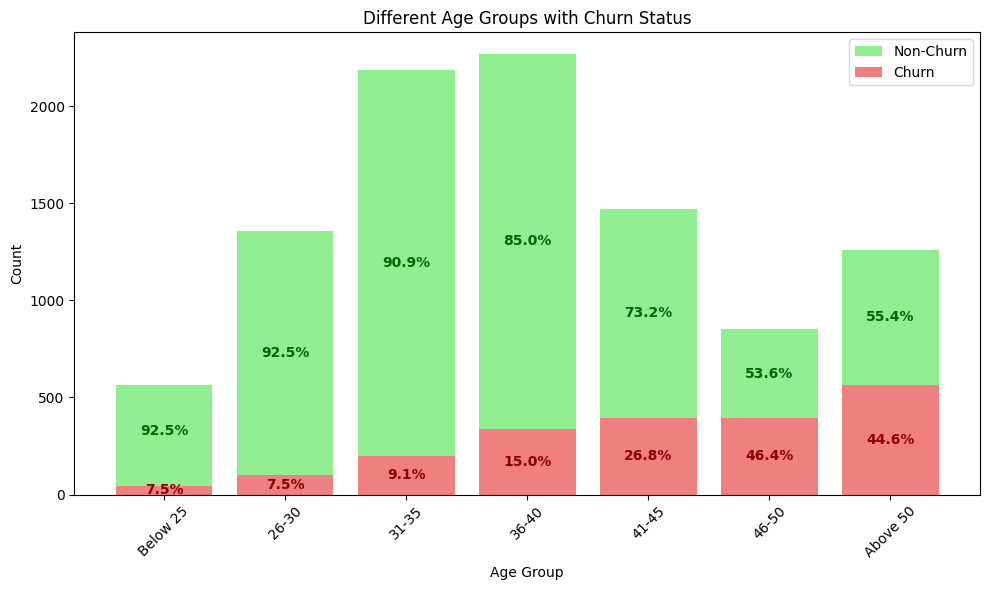

In [ ]:
Age_bins = [0, 26, 31, 36, 41, 46, 51, float('inf')]
Age_labels = ['Below 25', '26-30', '31-35', '36-40','41-45','46-50','Above 50']
get_variable_distribution('Age', Age_bins, Age_labels,df)

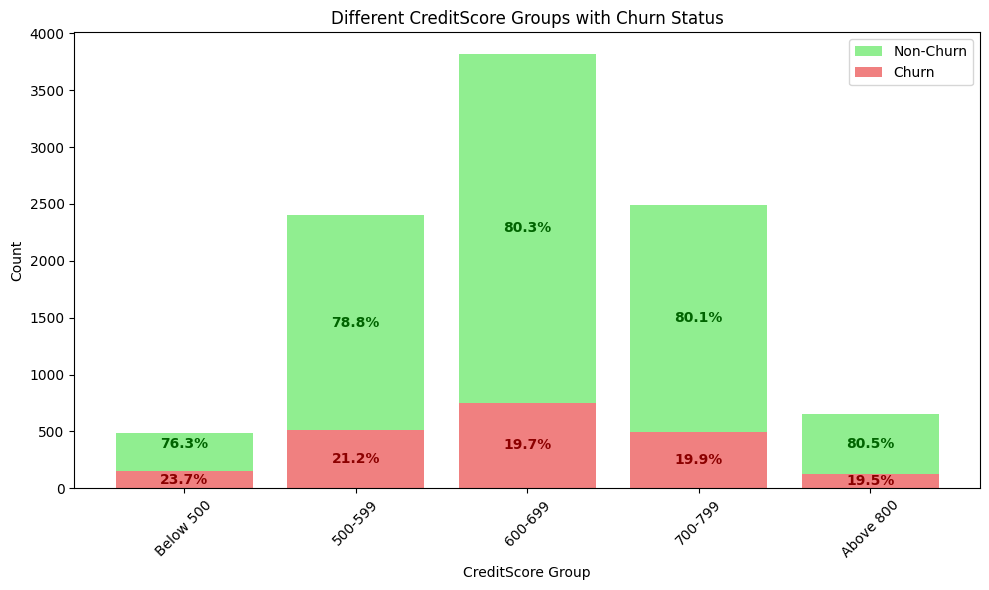

In [ ]:
CreditScore_bins = [0, 500, 600, 700, 800, float('inf')]
CreditScore_labels = ['Below 500', '500-599','600-699','700-799','Above 800']
get_variable_distribution('CreditScore', CreditScore_bins, CreditScore_labels,df)

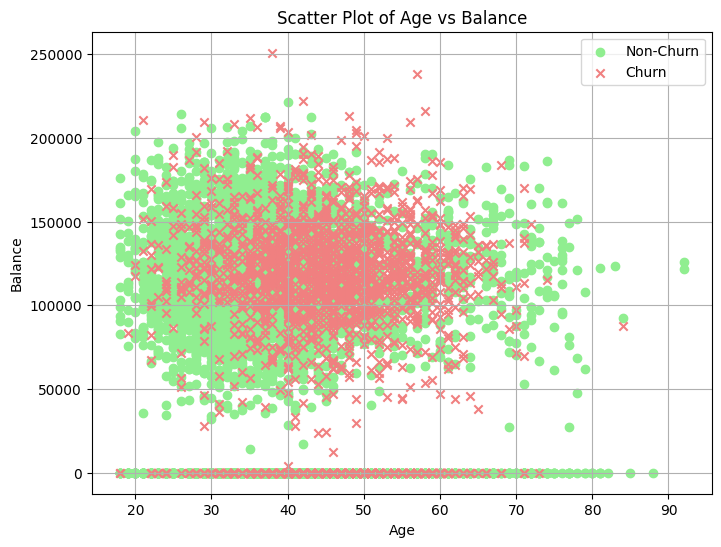

In [ ]:
# Separate data based on default status
Exit_data = df[df['Exited'] == 1]
Non_Exit_data = df[df['Exited'] == 0]

# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(Non_Exit_data['Age'], Non_Exit_data['Balance'], marker = 'o', label='Non-Churn', color='lightgreen', alpha=1)
plt.scatter(Exit_data['Age'], Exit_data['Balance'], marker='x', label='Churn', color='lightcoral', alpha=1)

plt.xlabel('Age')
plt.ylabel('Balance')
plt.title('Scatter Plot of Age vs Balance')
plt.legend()
plt.grid(True)
plt.show()

<Axes: xlabel='Exited', ylabel='EstimatedSalary'>

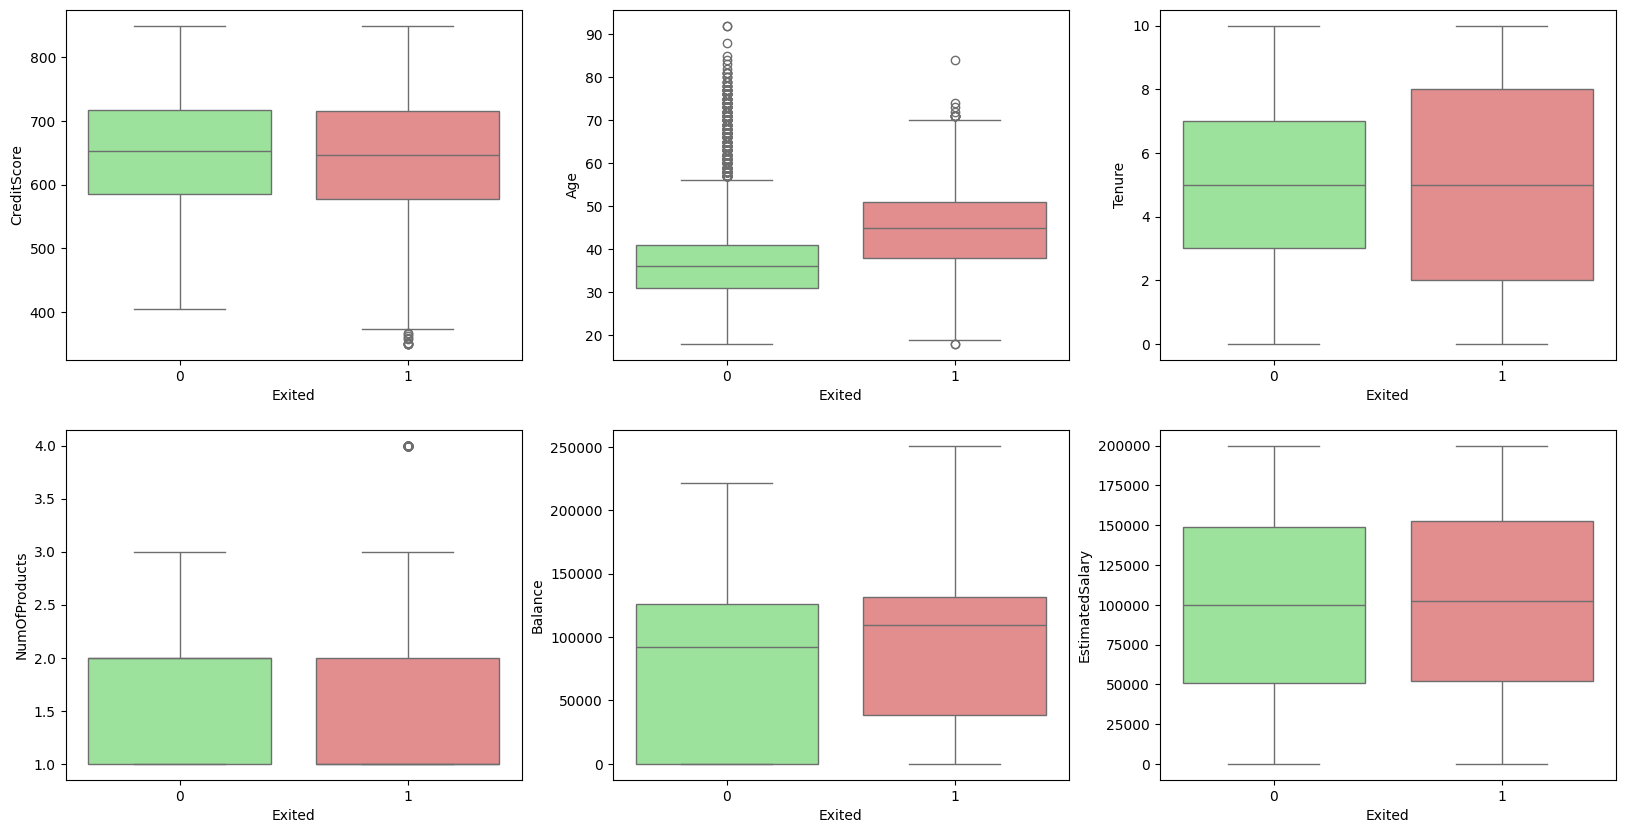

In [ ]:
# Box plot to compare distributions for numerical data
_,axss = plt.subplots(2,3, figsize=[20,10])
sns.boxplot(x='Exited', y ='CreditScore', data=df, ax=axss[0][0],palette=colors)
sns.boxplot(x='Exited', y ='Age', data=df, ax=axss[0][1],palette=colors)
sns.boxplot(x='Exited', y ='Tenure', data=df, ax=axss[0][2],palette=colors)
sns.boxplot(x='Exited', y ='NumOfProducts', data=df, ax=axss[1][0],palette=colors)
sns.boxplot(x='Exited', y ='Balance', data=df, ax=axss[1][1],palette=colors)
sns.boxplot(x='Exited', y ='EstimatedSalary', data=df, ax=axss[1][2],palette=colors)

<Axes: xlabel='Exited', ylabel='count'>

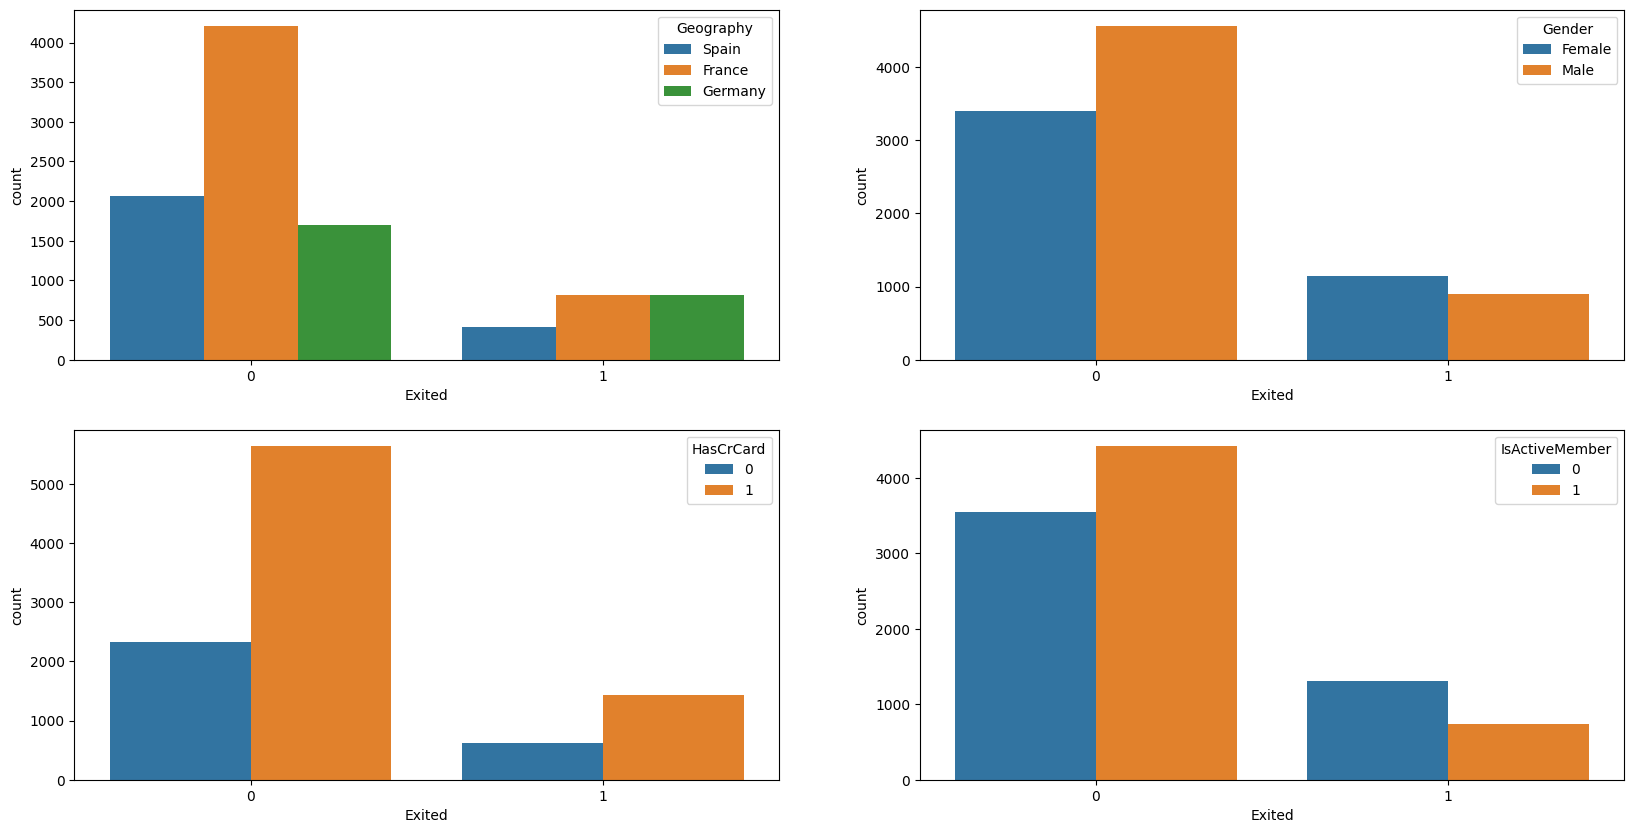

In [ ]:
# Box plot to compare distributions for categorical data
_,axss = plt.subplots(2,2, figsize=[20,10])
sns.countplot(x='Exited', hue='Geography', data=df, ax=axss[0][0])
sns.countplot(x='Exited', hue='Gender', data=df, ax=axss[0][1])
sns.countplot(x='Exited', hue='HasCrCard', data=df, ax=axss[1][0])
sns.countplot(x='Exited', hue='IsActiveMember', data=df, ax=axss[1][1])

## Section3: Feature Processing -- Feature Selection & Feature Engineering

### Part1: Feature Selection

Numerical Predictor:

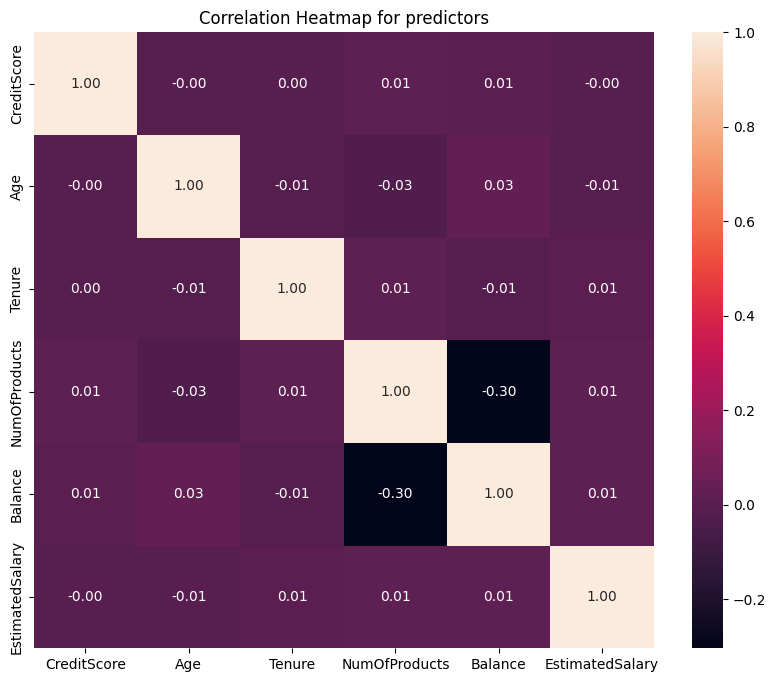

In [ ]:
# Create a Correlation Map -- Check multicollinearity
correlation_matrix = df[['CreditScore', 'Age', 'Tenure', 'NumOfProducts','Balance', 'EstimatedSalary']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True,fmt=".2f")
plt.title("Correlation Heatmap for predictors")
plt.show()

Categorical Predictor:

In [ ]:
#Perform Chi-Square tests:
#Null Hypothesis: Two variables are Independent, Alternative Hypothesis: Dependent
#P-val < 0.05 Dependent, p-val >0.05 Independent
#P-val: The probability of observing as or more extreme results than the current observation under the null hypothesis.
#In feature selection, we aim to select the features that are highly dependent on the response

from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table1 = pd.crosstab(df['Geography'], df['Exited'])
contingency_table2 = pd.crosstab(df['Gender'], df['Exited'])
contingency_table3 = pd.crosstab(df['HasCrCard'], df['Exited'])
contingency_table4 = pd.crosstab(df['IsActiveMember'], df['Exited'])
chi2, p1, dof, expected = chi2_contingency(contingency_table1)
chi2_, p2, dof_, expected_ = chi2_contingency(contingency_table2)
chi2, p3, dof, expected = chi2_contingency(contingency_table3)
chi2_, p4, dof_, expected_ = chi2_contingency(contingency_table4)
# Print the results
print("P-value:", p1,p2,p3,p4)

P-value: 3.8303176053541544e-66 2.2482100097131755e-26 0.49237236141554686 8.785858269303703e-55


Rule of Thumb: Never drop features in the first place!

We can build different Skeleton to test the best one:
- Model 1: Full Feature
- Model 2: Full Feature without HasCrCard

### Part2: Feature Engineering
- One Hot Encoding for Categorical Feature
- Normalization/Standardization for Numerical Feature

In [ ]:
X = df.drop(['Exited'], axis=1)
y = df['Exited']

In [ ]:
X.dtypes

CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
dtype: object

In [ ]:
#Extract the cat&num column name for later feature processing purposes
cat_cols = X.columns[X.dtypes == 'object'] #categorical data
num_cols = X.columns[(X.dtypes == 'float64') | (X.dtypes == 'int64')] #numerical data

In [ ]:
print("categorical columns are: ", cat_cols)
print("numerical columns are: ", num_cols)

categorical columns are:  Index(['Geography', 'Gender'], dtype='object')
numerical columns are:  Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary'],
      dtype='object')


In [ ]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, stratify = y, random_state=1) #stratified sampling

print('training data has ' + str(X_train.shape[0]) + ' observation with ' + str(X_train.shape[1]) + ' features')
print('test data has ' + str(X_test.shape[0]) + ' observation with ' + str(X_test.shape[1]) + ' features')

training data has 7500 observation with 10 features
test data has 2500 observation with 10 features


In [ ]:
# One-hot Encoding
from sklearn.preprocessing import OneHotEncoder

def OneHotEncoding(df, enc, categories):
  transformed = pd.DataFrame(enc.transform(df[categories]).toarray(), columns=enc.get_feature_names_out(categories))
  return pd.concat([df.reset_index(drop=True), transformed], axis=1).drop(categories, axis=1)

categories = ['Geography']
encoder_ohe = OneHotEncoder()
encoder_ohe.fit(X_train[categories])

X_train = OneHotEncoding(X_train, encoder_ohe, categories)
X_test = OneHotEncoding(X_test, encoder_ohe, categories)

In [ ]:
X_train.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain
0,633,Male,42,10,0.00,1,0,1,79408.17,0.0,0.0,1.0
1,708,Female,23,4,71433.08,1,1,0,103697.57,0.0,1.0,0.0
2,548,Female,37,9,0.00,2,0,0,98029.58,1.0,0.0,0.0
3,645,Female,48,7,90612.34,1,1,1,149139.13,1.0,0.0,0.0
4,729,Female,45,7,91091.06,2,1,0,71133.12,0.0,0.0,1.0


In [ ]:
# One hot encoding method 2 - Using OrdinalEncoder, in this step, one hot encoding the 'Gender'
# Note: Ordinal Encoder is directly assign value, so for case more than 2 will not be a good choice
from sklearn.preprocessing import OrdinalEncoder

categories = ['Gender']

#model1
encoder_oe = OrdinalEncoder()
encoder_oe.fit(X_train[categories])
X_train[categories] = encoder_oe.transform(X_train[categories])
X_test[categories] = encoder_oe.transform(X_test[categories])

In [ ]:
X_train.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain
0,633,1.0,42,10,0.00,1,0,1,79408.17,0.0,0.0,1.0
1,708,0.0,23,4,71433.08,1,1,0,103697.57,0.0,1.0,0.0
2,548,0.0,37,9,0.00,2,0,0,98029.58,1.0,0.0,0.0
3,645,0.0,48,7,90612.34,1,1,1,149139.13,1.0,0.0,0.0
4,729,0.0,45,7,91091.06,2,1,0,71133.12,0.0,0.0,1.0


Now, we are done with the categorical feature, lets fix the numerical feature

In [ ]:
# Scale the data, using standardization
# standardization (x-mean)/std
# normalization (x-x_min)/(x_max-x_min) ->[0,1] #standardization和normalization看哪个效果好用哪个

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train[num_cols])
X_train[num_cols] = scaler.transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [ ]:
X_train.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain
0,-0.172985,1.0,0.289202,1.731199,-1.218916,-0.912769,-1.542199,0.968496,-0.352044,0.0,0.0,1.0
1,0.602407,0.0,-1.509319,-0.341156,-0.076977,-0.912769,0.648425,-1.032529,0.072315,0.0,1.0,0.0
2,-1.051762,0.0,-0.184093,1.385806,-1.218916,0.796109,-1.542199,-1.032529,-0.026711,1.0,0.0,0.0
3,-0.048922,0.0,0.857156,0.695022,0.229625,-0.912769,0.648425,0.968496,0.866221,1.0,0.0,0.0
4,0.819517,0.0,0.573179,0.695022,0.237278,0.796109,0.648425,-1.032529,-0.496617,0.0,0.0,1.0


Create the final form for model1 and model2 prepare for modeling

In [ ]:
X_train_m1 = X_train
X_test_m1 = X_test
X_train_m2 = X_train.drop(columns = ['HasCrCard'])
X_test_m2 = X_test.drop(columns = ['HasCrCard'])

In [ ]:
X_train_m2.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain
0,-0.172985,1.0,0.289202,1.731199,-1.218916,-0.912769,0.968496,-0.352044,0.0,0.0,1.0
1,0.602407,0.0,-1.509319,-0.341156,-0.076977,-0.912769,-1.032529,0.072315,0.0,1.0,0.0
2,-1.051762,0.0,-0.184093,1.385806,-1.218916,0.796109,-1.032529,-0.026711,1.0,0.0,0.0
3,-0.048922,0.0,0.857156,0.695022,0.229625,-0.912769,0.968496,0.866221,1.0,0.0,0.0
4,0.819517,0.0,0.573179,0.695022,0.237278,0.796109,-1.032529,-0.496617,0.0,0.0,1.0
